In [1]:
import os
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
from sklearn.preprocessing import normalize

import matplotlib.patches as mpatches

from activ.nmf.viz import bases_heatmap
from activ import TrackTBIFile
from activ.viz import venn5, venn5_count

from activ.paper import plot_cat2cont


/Users/ajtritt/anaconda3/envs/activ/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tbifile = TrackTBIFile('../tracktbi.scalar.h5')
stack_path = '../paper/biomarkers_stack.png'
venn_path = '../paper/outcome_venn5_mpl.png'
venn_data_path = '../patient_phenotype_var_count_V1.0.csv'

In [3]:
df = pd.DataFrame(data=np.concatenate([tbifile.biomarkers, tbifile.outcomes], axis=1),
                  columns=np.concatenate([tbifile.biomarker_features, tbifile.outcome_features]),
                  index=tbifile.patient_ids)

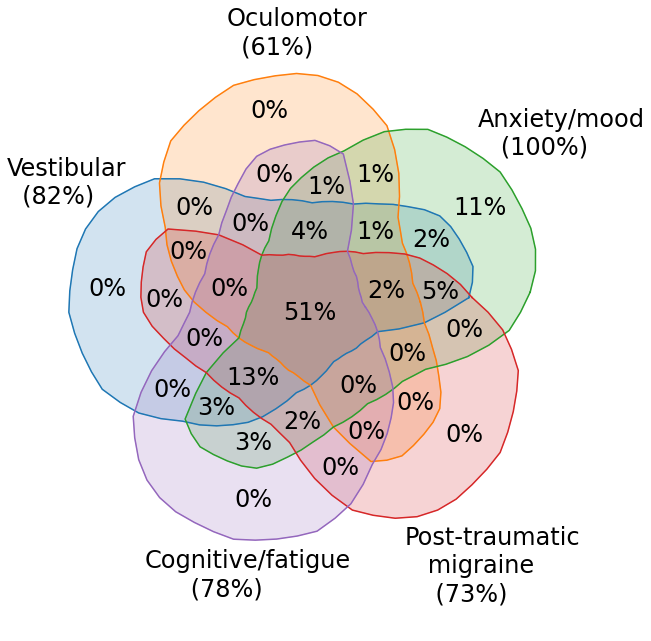

In [4]:
plt.figure(figsize=(9,9))
venn_df = pd.read_csv(venn_data_path, index_col=0)
labels, counts = venn5_count(venn_df.values)
venn_counts = ["%0.0f%%" % p for p in (100*counts)/counts.sum()]

def fmt(l, p):
    pstr = "(%0.0f%%)" % p
    l = l + "\n" + pstr
    lvls = l.split("\n")
    w = np.max([len(_) for _ in lvls])
    ret = ""
    for lvl in lvls:
        sp = " " * ((w - len(lvl))//2)
        ret += (sp + lvl +  "\n")
    return ret #l + "\n" + sp + pstr

labels = ["Vestibular", "Oculomotor", "Anxiety/mood", "Post-traumatic\nmigraine", "Cognitive/fatigue"]
labels = [fmt(*_) for _ in zip(labels, (venn_df.values > 0 ).mean(axis=0)*100)]

ax = plt.gca()
venn5(venn_counts, ax=ax, labels=labels, countsize=24, labelsize=24) #[s.replace('_', ' ') for s in df.columns])
plt.tight_layout()
plt.savefig(venn_path, dpi=100)

30 24 18
(227, 237, 4)
(900, 900, 4)


/Users/ajtritt/anaconda3/envs/activ/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


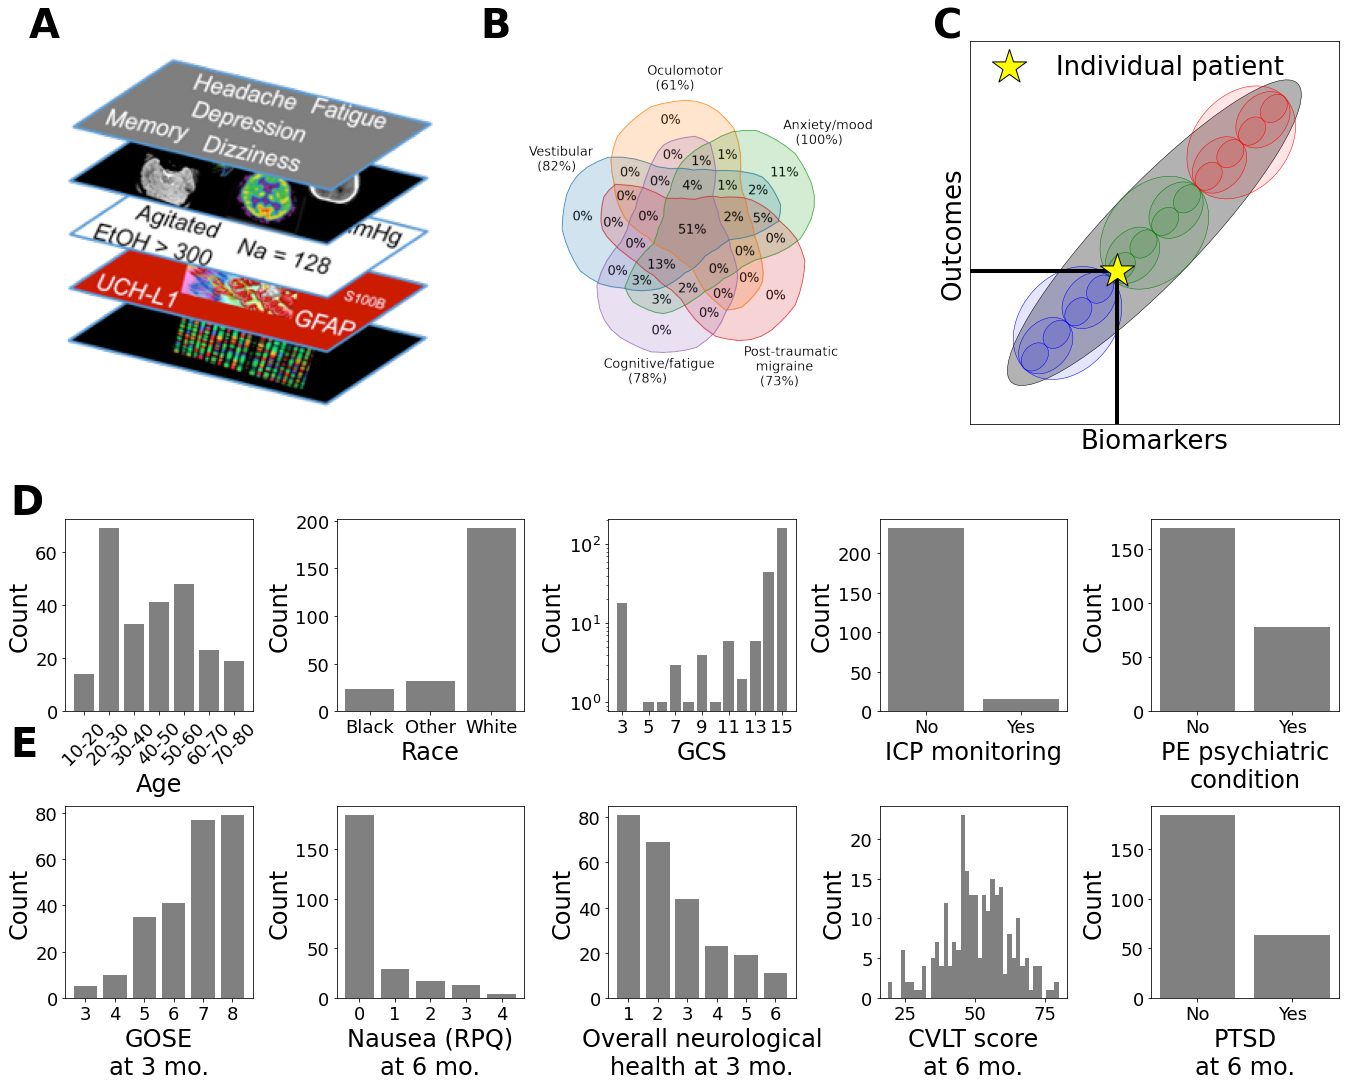

In [5]:
factor = 3
WID = 6.5
fig = plt.figure(figsize=(WID * factor, WID * 7/9 * factor), tight_layout=True)

base = 10
fs_L = base * factor
fs_M = (base - 2) * factor
fs_S = (base - 4) * factor

print(fs_L, fs_M, fs_S)


def get_col(m, feats, colname):
    col = None
    idx = np.where(feats == varname)[0]
    if len(idx) > 0:
        idx = idx[0]
        col = m[:, idx]
    return col
    
def add_name(func):
    def ret(ax, col, name=None):
        func(ax, col)
        ax.set_xlabel(name or col.name, fontsize=fs_M)
    return ret

@add_name
def make_barplot(ax, col):
    vals, counts = np.unique(col, return_counts=True)
    ax.bar([str(v) for v in vals], counts, color='gray')

@add_name
def make_barplot_ints(ax, col):
    vals, counts = np.unique(col, return_counts=True)
    ax.bar([str(int(v)) for v in vals], counts, color='gray')
    
@add_name
def make_age(ax, col):
    counts, edges = np.histogram(col, bins=np.arange(1,9)*10)
    names = [f'{b}-{e}' for b, e in zip(edges[:-1], edges[1:])]
    ax.tick_params('x', labelrotation=45, labelsize=fs_S+2)
    ax.bar(names, counts, color='gray')

@add_name
def make_gcs(ax, col):
    vals, counts = np.unique(col, return_counts=True)
    vals = vals.astype(int)
    mask = vals >= 13
    ax.bar(vals[mask], counts[mask], color='gray', label='Mild')
    mask = np.logical_and(np.logical_not(mask), vals >= 9)
    ax.bar(vals[mask], counts[mask], color='gray', label='Moderate')
    mask = np.logical_and(np.logical_not(mask), vals < 9)
    ax.bar(vals[mask], counts[mask], color='gray', label='Severe')
    ax.set_xticks(np.arange(1,8)*2+1)
    ax.set_xticklabels(np.arange(1,8)*2+1)
    ax.set_yscale('log')
    #ax.legend()

@add_name
def make_yes_no(ax, col):
    vals, counts = np.unique(col, return_counts=True)
    vals = ['No', 'Yes']
    ax.bar(vals, counts, color='gray')

def make_race(ax, df):
    ar = np.zeros(len(df), dtype='U5')
    ar[df['RACE_3CAT_Black'] == 1] = 'Black'
    ar[df['RACE_3CAT_White'] == 1] = 'White'
    ar[df['RACE_3CAT_Other'] == 1] = 'Other'
    make_barplot(ax, pd.Series(data=ar, name='Race'))
    
@add_name
def make_hist(ax, col):
    ax.hist(col, bins=40, color='gray')
    
def add_label(ax, label, x=-0.1, y=1.01):
    #ax.text(-0.1, 1.01, label, transform=ax.transAxes, weight='bold', size=30)
    ax.text(x, y, label, transform=ax.transAxes, weight='bold', size=fs_L+10)
    #ax.text(-0.3, 1.01, label, transform=ax.transAxes, weight='bold', size=30)
    ax.axis('off')
    

def standardize(ar, x=300):
    shape = (x, x, ar.shape[2])
    ret = np.zeros(shape)
    row_s = (x - ar.shape[0])//2
    row_e = row_s + ar.shape[0]
    col_s = (x - ar.shape[1])//2
    col_e = col_s + ar.shape[1]
    ret[row_s:row_e, col_s:col_e] = ar
    return ret



C = 1
x = 5*C
y = 3*C
gs = fig.add_gridspec(x+2*y, 3*x)
axStack = fig.add_subplot(gs[:x, :x])

axVenn = fig.add_subplot(gs[:x, x:2*x])
axCat2Con = fig.add_subplot(gs[:x, 2*x:])

stack = plt.imread(stack_path)
print(stack.shape)
venn = plt.imread(venn_path)


stack = np.array([np.kron(stack[:, :, i], np.ones((4,4))).T for i in range(stack.shape[-1])]).T


print(venn.shape)
max_dim = max((max(stack.shape), max(venn.shape)))
stack = standardize(stack, max_dim)
venn = standardize(venn, max_dim)

axStack.imshow(stack)
axVenn.imshow(venn)



axStack.axis('off')
axVenn.axis('off')

plot_cat2cont(axCat2Con, fontsize=fs_M + 2, marker_size=(fs_M * 1.5)**2)


axes = np.zeros((2,5), dtype=object)
axes[0, 0] = fig.add_subplot(gs[x:x+y,   0:y  ])
axes[0, 1] = fig.add_subplot(gs[x:x+y,   y:2*y])
axes[0, 2] = fig.add_subplot(gs[x:x+y, 2*y:3*y])
axes[0, 3] = fig.add_subplot(gs[x:x+y, 3*y:4*y])
axes[0, 4] = fig.add_subplot(gs[x:x+y, 4*y:])

axes[1, 0] = fig.add_subplot(gs[x+y:,   0:y  ])
axes[1, 1] = fig.add_subplot(gs[x+y:,   y:2*y])
axes[1, 2] = fig.add_subplot(gs[x+y:, 2*y:3*y])
axes[1, 3] = fig.add_subplot(gs[x+y:, 3*y:4*y])
axes[1, 4] = fig.add_subplot(gs[x+y:, 4*y:   ])


make_age(axes[0, 0], df['Age'], name="Age")
make_race(axes[0, 1], df)
make_gcs(axes[0, 2], df['admGCS'], name="GCS")
make_yes_no(axes[0, 3], df['ICPMonitorYesNo'], name="ICP monitoring")
make_yes_no(axes[0, 4], df['PMH_Psych_ANY'], name="PE psychiatric\ncondition")

make_barplot_ints(axes[1, 0], df['GOSE_OverallScore3M'], name='GOSE\nat 3 mo.')

make_barplot_ints(axes[1, 1], df['RPQNausea_6mo'], name="Nausea (RPQ)\nat 6 mo.")
make_barplot_ints(axes[1, 2], df['NeuroOverallRating3mo'], name='Overall neurological\nhealth at 3 mo.')
make_hist(axes[1, 3], df['CVLTTrial1To5StandardScore_6mo'], name="CVLT score\nat 6 mo.")
make_yes_no(axes[1, 4], df['PTSD_6mo'], name="PTSD\nat 6 mo.")

for ax in axes.ravel():
    ax.set_ylabel("Count", fontsize=fs_M)
    ax.tick_params('both', labelsize=fs_S)



add_label(fig.add_subplot(gs[:x, :x], label='Albl'), 'A')
add_label(fig.add_subplot(gs[:x, x:2*x], label='Blbl'), 'B')
add_label(fig.add_subplot(gs[:x, 2*x:], label='Clbl'), 'C')


ax = fig.add_subplot(gs[x:x+2*y, 0:2*y], label='Dlbl')
ax.text(-0.12, 1.01, 'D', transform=ax.transAxes, weight='bold', size=fs_L+10)
ax.text(-0.12, 0.505, 'E', transform=ax.transAxes, weight='bold', size=fs_L+10)
ax.axis('off')

#fig.set_constrained_layout(False)
fig.savefig("../paper/tracktbi_summary.png", dpi=100)
